<a href="https://colab.research.google.com/github/7pupuwen/PCB_QDETECTION/blob/main/PCB_Detection_feature_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
! pip install pennylane -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 36.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 63.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 55.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 53.3 MB/s eta 0:00:00


In [4]:
api_token = {"username":"doudoutz","key":"0c5febc722e952ed3a94be3165401d06"}
import json
import zipfile
import os

if not os.path.exists("/root/.kaggle"):
    os.makedirs("/root/.kaggle")

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)
!chmod 600 /root/.kaggle/kaggle.json

if not os.path.exists("/kaggle"):
    os.makedirs("/kaggle")
os.chdir('/kaggle')

!kaggle datasets download -d norbertelter/pcb-defect-dataset -q
!unzip -q pcb-defect-dataset.zip -d pcb_data

Dataset URL: https://www.kaggle.com/datasets/norbertelter/pcb-defect-dataset
License(s): unknown


In [5]:
#export KAGGLE_USERNAME=doudoutz
#export KAGGLE_KEY=0c5febc722e952ed3a94be3165401d06

In [6]:
import os
import pandas as pd

# Set the label files
train_labels_path = "/kaggle/pcb_data/pcb-defect-dataset/train/labels"
val_labels_path = "/kaggle/pcb_data/pcb-defect-dataset/val/labels"
test_labels_path = "/kaggle/pcb_data/pcb-defect-dataset/test/labels"

# Definition of convert label to csv
def convert_labels_to_csv(labels_path, output_csv):
    data = []

    # read every .txt file
    for file in os.listdir(labels_path):
        if file.endswith(".txt"):
            file_path = os.path.join(labels_path, file)
            image_name = file.replace(".txt", ".jpg")  # The file name corresponding to the image
            with open(file_path, "r") as f:
                lines = f.readlines()  #A .txt may have multiple lines of tags

                for line in lines:
                    values = line.strip().split()
                    class_id = int(values[0])  # Defect category
                    x_center, y_center, width, height = map(float, values[1:])  # Analyze numerical values

                    # Save to DataFrame
                    data.append([image_name, class_id, x_center, y_center, width, height])

    # create DataFrame
    df = pd.DataFrame(data, columns=["image_name", "class_id", "x_center", "y_center", "width", "height"])

    # Save as CSV
    df.to_csv(output_csv, index=False)

    print(f"{output_csv} convert finish！")
    print(df.head(10))  # show the first 10 data

# covert `train`、`val`、`test` labels
convert_labels_to_csv(train_labels_path, "train_labels.csv")
convert_labels_to_csv(val_labels_path, "val_labels.csv")
convert_labels_to_csv(test_labels_path, "test_labels.csv")

train_labels.csv convert finish！
                                        image_name  class_id  x_center  \
0            light_08_spurious_copper_07_3_256.jpg         5    0.1467   
1            light_08_spurious_copper_07_3_256.jpg         5    0.7642   
2            light_08_spurious_copper_07_3_256.jpg         5    0.4192   
3               light_04_open_circuit_07_2_256.jpg         4    0.6958   
4               light_04_open_circuit_07_2_256.jpg         4    0.2858   
5   rotation_90_light_05_open_circuit_05_1_600.jpg         4    0.4050   
6   rotation_90_light_05_open_circuit_05_1_600.jpg         4    0.5008   
7  rotation_270_light_05_missing_hole_01_2_600.jpg         2    0.2288   
8          rotation_90_light_09_short_06_1_600.jpg         3    0.6650   
9          rotation_90_light_09_short_06_1_600.jpg         3    0.8858   

   y_center   width  height  
0    0.7400  0.0367  0.0600  
1    0.7792  0.0417  0.0650  
2    0.9483  0.0350  0.0667  
3    0.0450  0.0317  0.0267  
4 

In [12]:
import os
import cv2
import numpy as np
import pandas as pd

#Set up image folder
train_images_path = "/kaggle/pcb_data/pcb-defect-dataset/train/images"
val_images_path = "/kaggle/pcb_data/pcb-defect-dataset/val/images"
test_images_path = "/kaggle/pcb_data/pcb-defect-dataset/test/images"

# Read tag CSV
train_labels_csv = "train_labels.csv"
val_labels_csv = "val_labels.csv"
test_labels_csv = "test_labels.csv"

# Define functions to read images and match tags
def load_images_and_labels(images_path, labels_csv):
    df = pd.read_csv(labels_csv)  # 讀取 CSV 標籤

    # 合併相同 image_name，取出最常出現的 class_id（單一標籤）
    df = df.groupby("image_name")["class_id"].agg(lambda x: x.value_counts().index[0]).reset_index()

    X, y = [], []

    for _, row in df.iterrows():
        img_path = os.path.join(images_path, row["image_name"])

        if os.path.exists(img_path):
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)   # 灰階
            img = cv2.resize(img, (64, 64)) / 255.0             # Resize + normalize
            X.append(img)
            y.append(row["class_id"])  # 注意這裡只剩下唯一 class_id

    # 轉成 NumPy
    X = np.array(X)
    y = np.array(y)

    print(f"{labels_csv} processed, image data size: {X.shape}, label data size: {y.shape}")
    return X, y

# read `train`、`val`、`test` data
X_train, y_train = load_images_and_labels(train_images_path, train_labels_csv)
X_val, y_val = load_images_and_labels(val_images_path, val_labels_csv)
X_test, y_test = load_images_and_labels(test_images_path, test_labels_csv)

train_labels.csv processed, image data size: (6370, 64, 64), label data size: (6370,)
val_labels.csv processed, image data size: (802, 64, 64), label data size: (802,)
test_labels.csv processed, image data size: (829, 64, 64), label data size: (829,)


In [13]:
# Choose label=0&1
X_train_0 = X_train[y_train == 0]
y_train_0 = y_train[y_train == 0]

X_train_1 = X_train[y_train == 1]
y_train_1 = y_train[y_train == 1]

X_val_0 = X_val[y_val == 0]
y_val_0 = y_val[y_val == 0]

X_val_1 = X_val[y_val == 1]
y_val_1 = y_val[y_val == 1]

X_test_0 = X_test[y_test == 0]
y_test_0 = y_test[y_test == 0]

X_test_1 = X_test[y_test == 1]
y_test_1 = y_test[y_test == 1]

print(f"label=0 訓練數據數量: {X_train_0.shape}")
print(f"label=0 訓練數據數量: {X_val_0.shape}")
print(f"label=0 訓練數據數量: {X_test_0.shape}")

print(f"訓練資料 label=1 數量: {X_train_1.shape}")
print(f"驗證資料 label=1 數量: {X_val_1.shape}")
print(f"測試資料 label=1 數量: {X_test_1.shape}")


label=0 訓練數據數量: (1118, 64, 64)
label=0 訓練數據數量: (140, 64, 64)
label=0 訓練數據數量: (131, 64, 64)
訓練資料 label=1 數量: (1046, 64, 64)
驗證資料 label=1 數量: (130, 64, 64)
測試資料 label=1 數量: (138, 64, 64)


(<Figure size 800x500 with 1 Axes>, <Axes: >)

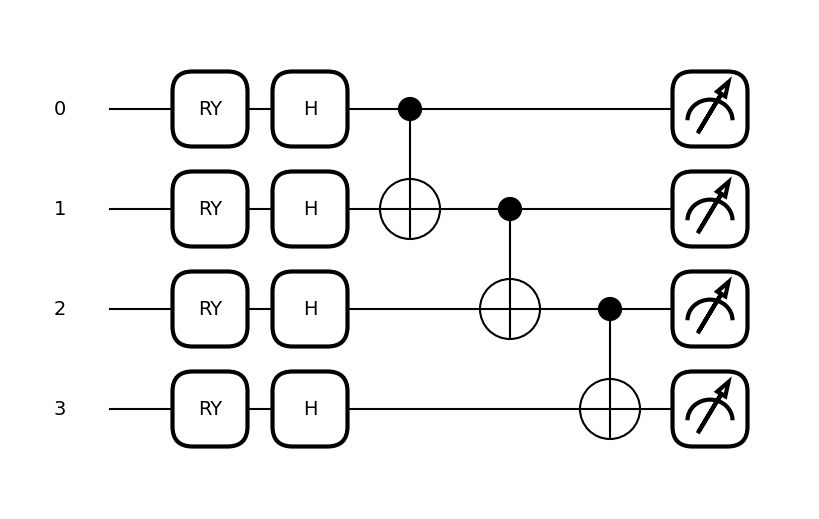

In [14]:
import pennylane as qml
import numpy as np

n_qubits = 4
dev = qml.device("default.qubit", wires=n_qubits, shots=1000)  # 多次測量以模擬現實

@qml.qnode(dev)
def quantum_kernel(x):
    """
    接收一個 2x2 patch（flatten 後長度為 4），
    回傳每個 qubit 在 Z、X 軸的期望值（共 8 維特徵）
    """
    # 資料嵌入
    for i in range(n_qubits):
        qml.RY(x[i] * np.pi, wires=i)  # 用 RY 輸入影像像素
        qml.Hadamard(wires=i)

    # 加入糾纏（局部 entanglement）
    for i in range(n_qubits - 1):
        qml.CNOT(wires=[i, i + 1])

    # 測量 Pauli Z + X 軸的期望值
    z_expectations = [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]
    x_expectations = [qml.expval(qml.PauliX(i)) for i in range(n_qubits)]

    return z_expectations + x_expectations  # 共 8 維特徵向量

x_test = np.random.rand(4)  # 產生 4 個隨機數
qml.draw_mpl(quantum_kernel)(x_test)

In [15]:
def quanvolution(image):
    """
    對影像套用量子卷積，提取每個 2x2 patch 的 Z+X 特徵（共 8 維）
    最後輸出 flatten 的特徵向量。
    """
    output_shape = (image.shape[0] // 2, image.shape[1] // 2, 8)  # 每個 patch 會對應 8 維特徵
    q_image = np.zeros(output_shape)

    for i in range(0, image.shape[0], 2):
        for j in range(0, image.shape[1], 2):
            patch = image[i:i+2, j:j+2].flatten()
            q_features = quantum_kernel(patch)
            q_image[i // 2, j // 2] = q_features

    return q_image.flatten()  # 回傳 flatten 過後的特徵向量（可接分類器）

In [16]:
X_train_0 = np.array([quanvolution(img) for img in X_train_0])
X_val_0 = np.array([quanvolution(img) for img in X_val_0])
X_test_0 = np.array([quanvolution(img) for img in X_test_0])

print(" X_train_0 shape:", X_train_0.shape)  # (84, 特徵數)
print(" X_val_0 shape:", X_val_0.shape)      # (88, 特徵數)
print("X_test_0 shape:", X_test_0.shape)    # (79, 特徵數)

 X_train_0 shape: (1118, 8192)
 X_val_0 shape: (140, 8192)
X_test_0 shape: (131, 8192)


In [17]:
X_train_1 = np.array([quanvolution(img) for img in X_train_1])
X_val_1 = np.array([quanvolution(img) for img in X_val_1])
X_test_1 = np.array([quanvolution(img) for img in X_test_1])

print(" X_train_1 shape:", X_train_1.shape)  # (84, 特徵數)
print(" X_val_1 shape:", X_val_1.shape)      # (82, 特徵數)
print("X_test_1 shape:", X_test_1.shape)    # (84, 特徵數)

 X_train_1 shape: (1046, 8192)
 X_val_1 shape: (130, 8192)
X_test_1 shape: (138, 8192)


In [18]:
# 合併 label=0 和 label=1 的量子特徵數據
X_train_01 = np.vstack([X_train_0, X_train_1])
y_train_01 = np.hstack([y_train_0, y_train_1])

print(f"合併後的訓練數據: {X_train_01.shape}")
print(f"合併後的標籤數據: {y_train_01.shape}")

X_val_01 = np.vstack([X_val_0, X_val_1])
y_val_01 = np.hstack([y_val_0, y_val_1])

print(f"合併後的訓練數據: {X_val_01.shape}")
print(f"合併後的標籤數據: {y_val_01.shape}")

X_test_01 = np.vstack([X_test_0, X_test_1])
y_test_01 = np.hstack([y_test_0, y_test_1])

print(f"合併後的訓練數據: {X_test_01.shape}")
print(f"合併後的標籤數據: {y_test_01.shape}")

合併後的訓練數據: (2164, 8192)
合併後的標籤數據: (2164,)
合併後的訓練數據: (270, 8192)
合併後的標籤數據: (270,)
合併後的訓練數據: (269, 8192)
合併後的標籤數據: (269,)


In [19]:
np.save("qcnn_features_X_train_01.npy", X_train_01)
np.save("qcnn_labels_y_train_01.npy", y_train_01)

np.save("qcnn_features_X_val_01.npy", X_val_01)
np.save("qcnn_labels_y_val_01.npy", y_val_01)

np.save("qcnn_features_X_test_01.npy", X_test_01)
np.save("qcnn_labels_y_test_01.npy", y_test_01)

In [20]:
from google.colab import files
files.download("qcnn_featuresy_train_01.npy")
files.download("qcnn_labelsy_train_01.npy")
files.download("qcnn_features_X_val_01.npy")
files.download("qcnn_labels_y_val_01.npy")
files.download("qcnn_features_X_test_01.npy")
files.download("qcnn_labels_y_test_01.npy")


FileNotFoundError: Cannot find file: qcnn_featuresy_train_01.npy

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def visualize_qcnn(image, quanvolution_func, patch_size=(2,2), feature_dim=8):
    """
    視覺化一張影像在 Quantum Convolution 前後的特徵變化。

    參數：
    - image: 原始影像（2D array，例如 4x4）
    - quanvolution_func: 你定義好的量子卷積函式（例如 quanvolution）
    - patch_size: patch 大小（預設 2x2）
    - feature_dim: 每個 patch 輸出幾維特徵（預設 8 維）
    """
    print("🎯 原始影像 shape:", image.shape)

    # 原始影像視覺化
    plt.figure(figsize=(3,3))
    plt.imshow(image, cmap='gray')
    plt.title("原始影像")
    plt.axis('off')
    plt.colorbar()
    plt.show()

    # 應用 QCNN
    q_features = quanvolution_func(image)
    print("🔍 QCNN 特徵 shape:", q_features.shape)

    # 轉換為 patches 結構
    patch_h = image.shape[0] // patch_size[0]
    patch_w = image.shape[1] // patch_size[1]
    q_patches = q_features.reshape(patch_h, patch_w, feature_dim)

    # 顯示每個 patch 的特徵向量
    print("\n📊 每個 Patch 的 8 維特徵：")
    for i in range(patch_h):
        for j in range(patch_w):
            print(f"Patch ({i}, {j}) 特徵:\n", q_patches[i, j])

    # 顯示某一維的特徵分布圖（可切換 k）
    for k in range(feature_dim):
        feature_map_k = q_patches[:, :, k]
        plt.imshow(feature_map_k, cmap='viridis')
        plt.title(f"第 {k} 維量子特徵分布")
        plt.colorbar()
        plt.show()

In [ ]:
i = 0  # 可以改成你想看的那一張
image = X_train_01[i]  # 一張 2D 影像（例如 4x4）

visualize_qcnn(image, quanvolution_func=quanvolution)